#Object Detection in Images via Machine Learning
####*Pavan Keerthi*
##### *Tuesday, May 12, 2015*

**SYNOPSIS :** Implements a Histogram of Oriented Gradients Algorithm for Object Detection

**DESCRIPTION :** In this example we train HOG detector algorithm with some Coke Can images and see if it can correclty predict presence of a coke can in an image

**PARAMETERS :** Trianing Images  
**OUTPUTS :** Object detection on images

**Version History**  
v0.1 - 12-May-2015 - Pavan Keerthi - Initial Version

### Setup

* We make use of following python libraries for this program

    [scikit-image][scikitimgref] : For Image processing .Further depends on [Numpy][Numpyref] and [Matplotlib][matplotlibref]  

    [dlib][dlibref] : A fast and accurate Machine learning library for Image object detection. Its written in C++ with Python bindings.  


        Note: You have to compile dlib & its parent boost C++ libraries from source 

[scikitimgref]: http://scikit-image.org/
[dlibref]: http://dlib.net/
[Numpyref]: http://www.numpy.org/
[matplotlibref]: http://matplotlib.org/


* I have downloaded some samples from google image search which is located in \images\train and \images\test folders

#### Import required Packages

In [2]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

#### Image Functions
Define some custom functions required . HatTip to this [Blog Post](http://blog.yhathq.com/posts/image-processing-with-scikit-image.html)

In [3]:
#Display a list of images in a pretty format
def show_images(images,titles=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.gray() 
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()
    
#Display a list of corners overlapping an image
def show_corners(corners,image,title=None):
    """Display a list of corners overlapping an image"""
    fig = plt.figure()
    plt.imshow(image)
    # Convert coordinates to x and y lists
    y_corner,x_corner = zip(*corners)
    plt.plot(x_corner,y_corner,'o') # Plot corners
    if title:
        plt.title(title)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0],0) # Images use weird axes
    fig.set_size_inches(np.array(fig.get_size_inches()) * 1.5)
    plt.show()
    print ("Number of corners : {0}".format(len(corners)))

###  1.Working with Images

In this section we explore some scikit-image procesing functions

Scikit-image allows us to read an image from disk and display it .The original image is converted to 3 dimensional Numpy array  where each dimension represents R,G,B colour channels

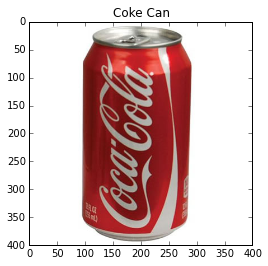

In [66]:
image=io.imread("images\\train\\img1.jpg")
show_images(images=[image],titles=["Coke Can"])

In [69]:
#Check the underlying representation of the image
print("Image Data type : {0}".format(type(image)))
print("Original Image Shape : {0}".format(image.shape))

Image Data type : <class 'numpy.ndarray'>
Original Image Shape : (400, 400, 3)


As we can see ,the image is represented as 400x400 Numpy array(matrix) with 3 channels .We can isolate the 3 RGB channels as show below

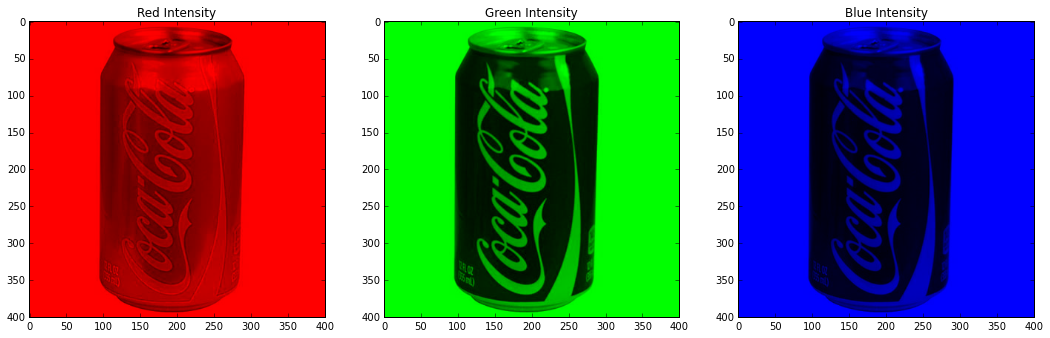

In [70]:
red, green, blue = image.copy(), image.copy(), image.copy()

red[:,:,(1,2)] = 0 #For Red,set Green and Blue channel pixel values to 0
green[:,:,(0,2)] = 0 #For Green,set Red and Blue channel pixel values to 0
blue[:,:,(0,1)] = 0 #For Blue,set Red and Green channel pixel values to 0

show_images(images=[red, green, blue], titles=['Red Intensity', 'Green Intensity', 'Blue Intensity'])

However,most image processing algorithms works well with grayscale of images. rb2gray function scikit-image lets us do that

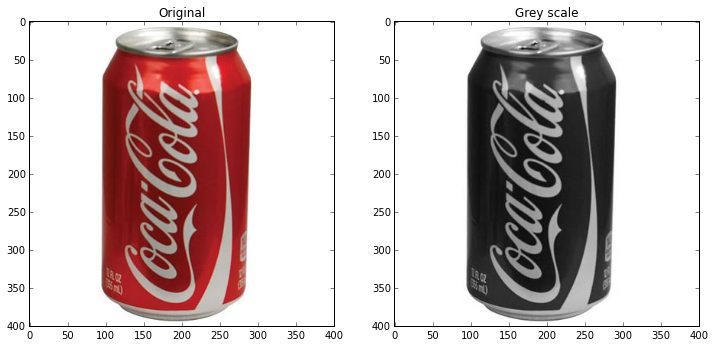

Grey Scale Image Shape : (400, 400)


In [77]:
from skimage.color import rgb2gray

grey_image = rgb2gray(image)
show_images(images=[image,grey_image],titles=['Original','Grey scale'])
print("Grey Scale Image Shape : {0}".format(grey_image.shape))

As you see above the grey scale is compressed down to a just 400x400 matrix.

Further,Image processing algorithms best work on blurred version of image (approximation of models) rather than exact representation

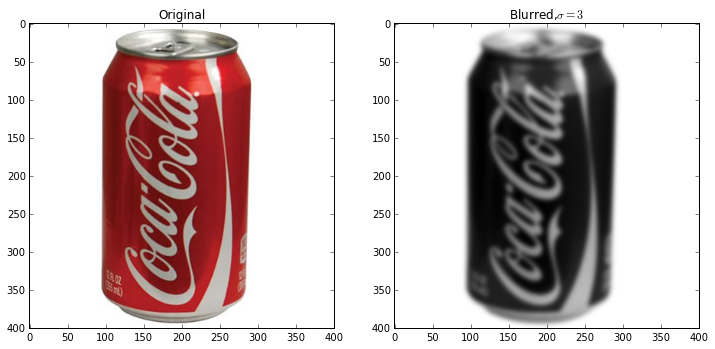

Blurred Image Shape : (400, 400)


In [76]:
from skimage.filter import gaussian_filter

blurred_image = gaussian_filter(gray_image,sigma=3)
show_images(images=[image,blurred_image],titles=['Original','Blurred,$\sigma=3$'])
print("Blurred Image Shape : {0}".format(blurred_image.shape))

### 2.Edge detection

One of the fundemental building blocks for object detection is to detect the edges of the object.Meaning,seperating foreground to background. This could be done by comparing and isolating pixel intensity values around a local block (say 1.cmx1.cm square block). Infact,scikit-image has a handy algorithm

#### Deteting Edges via Canny Algorithm

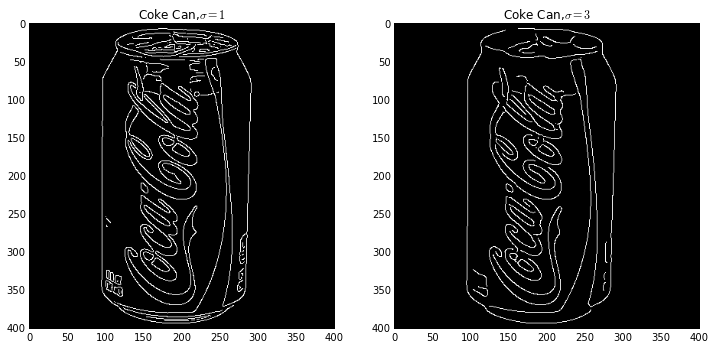

In [80]:
from skimage import feature

edges1 = feature.canny(gray_image,sigma=1)
edges2 = feature.canny(gray_image, sigma=3)

#display edges
show_images(images=[edges1,edges2],titles=["Coke Can,$\sigma=1$","Coke Can,$\sigma=3$"])

As you can see above,the canny algorithm has accurately identified the borders of Coke can(actually the paint on top of can)

### 3.Object Detection

Now,we come to the meat of the program. We need a way to seamlessly take a image,detect the edges and learn a model of our oject. There are many number of ways to do this  
* Cascading Haar Classifier  
* bag of Parts Model  
* Histogram of Oriented Gradients  
* Deep Learning  

Here We focus on using Histogram of Oriented Gradients Algorithm. Infact the excellent dlib C++ library is super fast ,needs less training examples and detects more accurately.To top it all it has python bindings.



In [82]:
import os
import sys
import glob
import dlib

In [83]:
images_folder = ".\\images\\train"

In [84]:
#Setting options for object detector algorithm.using same defaults as shown in 
#http://dlib.net/train_object_detector.py.html
options = dlib.simple_object_detector_training_options()
options.add_left_right_image_flips = True
options.C = 5
options.num_threads = 4 #my cpu cores
options.be_verbose = True

dlib comes with a tool imglab.exe to draw bounding boxes for training images. You have to compile it from source ,but once done.I drew boundaries around coke cans using these commands


**.\tools\imglab.exe -c ./images/train/objectboundaries.xml  ./images/train**  
This command creates a xml file with list of images

**.\tools\imglab.exe ./images/train/objectboundaries.xml**  
This command opens the draawing editor for you to add bounding boxes.Once file is saves then those box points are added into the xml file. 

In [29]:
#reference the xml file 
training_xml_path = os.path.join(images_folder, "objectboundaries.xml")

In [30]:
#train a simple object detector
dlib.train_simple_object_detector(training_xml_path,"detector.svm", options)

In [31]:
#reference the detector 
detector = dlib.simple_object_detector("detector.svm")

In [87]:
#see the HOg detector to check what it has learned about the object
win_det = dlib.image_window()
win_det.set_image(detector)

We can see the HOG detector from training samples 
<img src="files/HOG_detector.png">

From the above image ,we can see it has learned the approximate shape of our Coke can. 

Now lets try this model on some images stored in **images\test** folder . See the output below for detection summary and corresponding images


Processing file: .\images\test\img16.jpg
Number of objects detected: 1
Detection 0: Left: 18 Top: 161 Right: 190 Bottom: 534

Processing file: .\images\test\img17.jpg
Number of objects detected: 2
Detection 0: Left: 156 Top: 97 Right: 513 Bottom: 869
Detection 1: Left: 691 Top: 37 Right: 1048 Bottom: 810

Processing file: .\images\test\img18.jpg
Number of objects detected: 2
Detection 0: Left: 1328 Top: 45 Right: 1756 Bottom: 972
Detection 1: Left: 259 Top: 45 Right: 687 Bottom: 972

Processing file: .\images\test\img19.jpg
Number of objects detected: 2
Detection 0: Left: 87 Top: 39 Right: 230 Bottom: 349
Detection 1: Left: 333 Top: -39 Right: 505 Bottom: 362


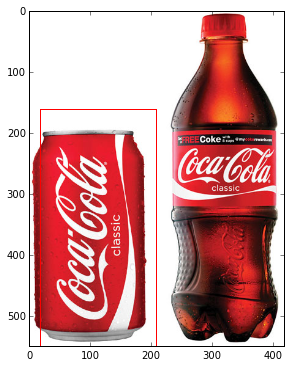

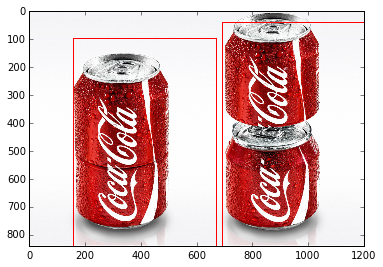

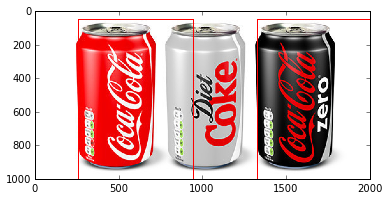

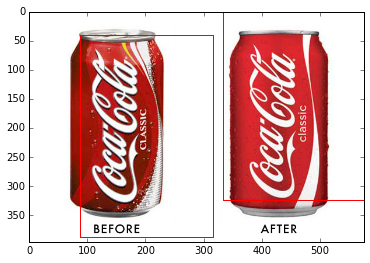

In [60]:
import matplotlib.patches as mpatches
for f in glob.glob(os.path.join(".\\images\\test", "*.jpg")):
    print("")
    print("Processing file: {}".format(f))
    img = io.imread(f)
    dets = detector(img)
    print("Number of objects detected: {}".format(len(dets)))
    
    fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(6, 6))
    
    for k, d in enumerate(dets):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))
        #Add img borders
        ax.add_patch(
            mpatches.Rectangle(
                (d.left(), d.top()),
                d.right(),
                d.bottom(),
                fill=False,      # remove background
                edgecolor="red" #borders
                )
            )
    ax.imshow(img)
        